# Data Analysis-- Supervised Learning
* Created on Mon Sep. 29 2021 by Shangying Wang
* Last Modified: Dec.15, 2021
* this code is used for prediction of the phenotypes from the combinatory motifs
* This code uses the convolutional neural network and LSTM.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import csv
import os
import matplotlib.pyplot as plt
from platform import python_version
print(python_version())

3.7.8


In [2]:
from tensorflow.keras.optimizers import SGD, Adam
from keras import layers,Sequential
from keras.layers import Lambda
from keras.layers import Input, Dense, Dropout, Flatten, Average, BatchNormalization, LSTM, TimeDistributed
from tensorflow.keras.layers import Conv1D,MaxPool1D, concatenate
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.initializers import RandomNormal,HeNormal,GlorotNormal,HeUniform,LecunNormal,LecunUniform,Orthogonal
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from itertools import product
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
print(tf.__version__)

2.6.0


# For arrayed data analysis

## Load data from csv file

In [3]:
train_data=pd.read_csv('data/array_randomseed2_training221_wseq.csv',encoding= 'unicode_escape',sep=',')
test_data=pd.read_csv('data/array_randomseed2_test25_wseq.csv',encoding= 'unicode_escape',sep=',')
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data.drop(['motif.5', 'AA Seq','Parts','NaiveCM'], axis=1, inplace=True)
test_data.drop(['motif.5', 'AA Seq','Parts','NaiveCM'], axis=1, inplace=True)
test_data

FileNotFoundError: [Errno 2] No such file or directory: 'data/array_randomseed2_training221_wseq.csv'

In [119]:
#data statistics
all_data = pd.concat([test_data, train_data])
max_cell=max(all_data['Cell Number'])
all_data['Cell Number']=all_data['Cell Number']/max_cell
train_data['Cell Number']=train_data['Cell Number']/max_cell
test_data['Cell Number']=test_data['Cell Number']/max_cell
stats_df = all_data.describe()
stats_df

,Cell Number,motif,motif.1,motif.2,motif.3,motif.4,Nalm 6 Cytotoxicity,IL7RaKLRG1 stemness
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000
mean,0.255184,7.252033,6.926829,7.300813,12.475610,0.739837,0.615778,18.648821
std,0.210155,3.910412,3.815480,3.995783,4.147954,3.138536,0.253641,8.116347
min,0.003385,1.000000,1.000000,0.000000,0.000000,0.000000,0.002313,4.490000
25%,0.103734,3.000000,3.000000,3.000000,14.000000,0.000000,0.431323,12.500000
50%,0.194125,8.000000,8.000000,8.000000,14.000000,0.000000,0.655914,16.950000
75%,0.324693,11.000000,10.000000,11.000000,14.000000,0.000000,0.820133,23.050000
max,1.000000,13.000000,14.000000,14.000000,14.000000,14.000000,1.197448,46.200000


In [120]:
skew_vals1=all_data['Nalm 6 Cytotoxicity'].skew()
skew_vals1

-0.24443600883940747

In [121]:
skew_vals2=all_data['IL7RaKLRG1 stemness'].skew()
skew_vals2

0.9435370705807998

Text(0.5, 1.0, 'after np.log1p')

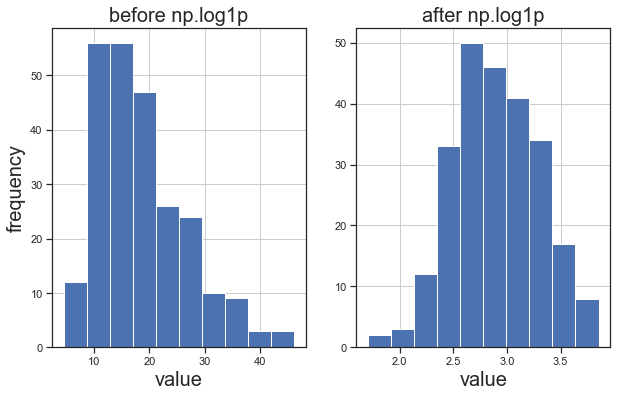

In [122]:
plt.figure(figsize=[10,20])
pheno=['IL7RaKLRG1 stemness']
new_data = all_data.copy()
pp=0
plt.subplot(3,2,1)
new_data[pheno[pp]].hist(bins=10)
plt.xlabel('value', fontsize=20)
plt.ylabel('frequency', fontsize=20)
plt.title('before np.log1p', fontsize=20)

plt.subplot(3,2,2)
new_data[pheno[pp]]=new_data[pheno[pp]].apply(np.log1p)
new_data[pheno[pp]].hist(bins=10)
plt.xlabel('value', fontsize=20)
#plt.ylabel('frequency', fontsize=20)
plt.title('after np.log1p', fontsize=20)

In [123]:
skew_vals2=new_data['IL7RaKLRG1 stemness'].skew()
skew_vals2

0.032751013323507376

In [124]:
train_data['IL7RaKLRG1 stemness'] = train_data['IL7RaKLRG1 stemness'].apply(np.log1p)
test_data['IL7RaKLRG1 stemness'] = test_data['IL7RaKLRG1 stemness'].apply(np.log1p)

In [125]:
stats_df = train_data.describe()
stats_df

,Cell Number,motif,motif.1,motif.2,motif.3,motif.4,Nalm 6 Cytotoxicity,IL7RaKLRG1 stemness
count,221.000000,221.00000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,0.257121,7.20362,6.791855,7.371041,12.656109,0.760181,0.628467,2.895283
std,0.211839,3.94959,3.800972,3.905459,3.898639,3.179687,0.252597,0.397182
min,0.003385,1.00000,1.000000,0.000000,0.000000,0.000000,0.004702,1.702928
25%,0.098971,3.00000,3.000000,3.000000,14.000000,0.000000,0.439604,2.602690
50%,0.209824,8.00000,8.000000,8.000000,14.000000,0.000000,0.666384,2.862201
75%,0.341985,11.00000,10.000000,11.000000,14.000000,0.000000,0.831310,3.173878
max,1.000000,13.00000,14.000000,14.000000,14.000000,14.000000,1.197448,3.854394


## Deep Neural Network for Nalm 6 Cytotoxicity

In [126]:
num_motifs=5
num_class=num_class=len(np.unique(new_data.iloc[:,1:(num_motifs+1)]))
np.unique(new_data.iloc[:,1:(num_motifs+1)])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [127]:
max_y=np.max(new_data['Nalm 6 Cytotoxicity'])
max_y

1.197447799

In [188]:
ICN_train, X_train, Y_train = train_data.iloc[:, :1], train_data.iloc[:,1:(num_motifs+1)], train_data['Nalm 6 Cytotoxicity']/max_y
ICN_test, X_test, Y_test = test_data.iloc[:, :1], test_data.iloc[:,1:(num_motifs+1)], test_data['Nalm 6 Cytotoxicity']/max_y

### One-hot encoding for 14 linear motifs: 

In [189]:
X_train_channel=to_categorical(X_train, num_classes=num_class)
X_test_channel=to_categorical(X_test, num_classes=num_class)
print(np.shape(X_test_channel)) #3D tensor with shape (batch_size, steps, features/channels)

(25, 5, 15)


In [190]:
output_dim = 1
batch_size = 10

In [191]:
stats_df = Y_train.describe()
stats_df

count    221.000000
mean       0.524839
std        0.210947
min        0.003927
25%        0.367118
50%        0.556504
75%        0.694235
max        1.000000
Name: Nalm 6 Cytotoxicity, dtype: float64

## GridSearchCV--search for the optimal hyperparameters  

In [192]:
np.shape(np.reshape(X_train_channel, [np.shape(X_train_channel)[0], -1]))

(221, 75)

In [233]:
#In order to tune the parameters, define deep NN structure as a tuning function
def create_model(filters=32, LSTM_units=4, dropout_rate1=0.2, fc_nodes=50):
    #seperate inputs:
    # create model
    input_all=Input(shape=(76,),name='input_all')
    input1=Lambda(lambda x: x[:,:-1])(input_all)
    input_position = tf.keras.layers.Reshape((num_motifs, num_class), input_shape=(75,))(input1)
    input_ICN = Lambda(lambda x: tf.expand_dims(x[:,-1],-1))(input_all) # (None,1)
                           
    x=Conv1D(filters=filters, kernel_size=3, padding='same', activation='relu', input_shape=(num_motifs, num_class))(1.0*input_position)
    x=LSTM(LSTM_units,return_sequences=True, dropout=dropout_rate1)(x)#return_sequences=True,
    x = Flatten()(x)
    model1 = keras.Model(inputs=input_all, outputs=x)


    # combine the output of the two branches
    combined = concatenate([model1.output, input_ICN])
    # apply a FC layer and then a regression prediction on the
    # combined outputs

    z = Dense(fc_nodes, activation='relu')(combined)
    z = Dropout(0.5)(z)
    z = Dense(1, activation='relu')(z)

    # our model will accept the inputs of the two branches and
    # then output a single value
    model = keras.Model(inputs=input_all, outputs=z)

    # Compile model
    model.compile(loss=keras.losses.MeanSquaredError(), optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

In [246]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
# create model
model_LSTM = KerasRegressor(build_fn=create_model)
# define the grid search parameters
# layer1_units = [16, 32, 64, 128]
# layer2_units=[3, 4, 5, 6]
# dropout_rate1=[0.1, 0.2, 0.3, 0.4, 0.5]
# dropout_rate2=[0.1, 0.2, 0.3, 0.4, 0.5]
filters = [16, 32, 48, 64, 80]
LSTM_units=[2, 4, 6, 8]
dropout_rate1=[0.1, 0.2, 0.3, 0.4]
fc_nodes=[32, 48, 64, 80, 96]
param_grid = dict(filters=filters, LSTM_units=LSTM_units, dropout_rate1=dropout_rate1, fc_nodes=fc_nodes)
LSTM_search = GridSearchCV(estimator=model_LSTM, param_grid=param_grid, cv=10, verbose=2)


In [247]:
## merge inputs
combine_input_train = np.concatenate([np.reshape(X_train_channel, [np.shape(X_train_channel)[0], -1]), ICN_train], axis=1)
combine_input_test = np.concatenate([np.reshape(X_test_channel, [np.shape(X_test_channel)[0], -1]), ICN_test], axis=1)

In [ ]:
## grid search to find the best model （This steps takes a long time to run)
best_model = LSTM_search.fit(combine_input_train, Y_train,  batch_size=batch_size,  epochs=1200, verbose=0)

Fitting 10 folds for each of 400 candidates, totalling 4000 fits
[CV] LSTM_units=2, dropout_rate1=0.1, fc_nodes=32, filters=16 ........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1/1 [==============================] - 0s 290ms/step - loss: 0.0160 - mean_squared_error: 0.0160
[CV]  LSTM_units=2, dropout_rate1=0.1, fc_nodes=32, filters=16, total=  55.2s
[CV] LSTM_units=2, dropout_rate1=0.1, fc_nodes=32, filters=16 ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.2s remaining:    0.0s


1/1 [==============================] - 0s 326ms/step - loss: 0.0230 - mean_squared_error: 0.0230
[CV]  LSTM_units=2, dropout_rate1=0.1, fc_nodes=32, filters=16, total=  54.9s
[CV] LSTM_units=2, dropout_rate1=0.1, fc_nodes=32, filters=16 ........
1/1 [==============================] - 0s 280ms/step - loss: 0.0223 - mean_squared_error: 0.0223
[CV]  LSTM_units=2, dropout_rate1=0.1, fc_nodes=32, filters=16, total=  51.1s
[CV] LSTM_units=2, dropout_rate1=0.1, fc_nodes=32, filters=16 ........
1/1 [==============================] - 0s 267ms/step - loss: 0.0240 - mean_squared_error: 0.0240
[CV]  LSTM_units=2, dropout_rate1=0.1, fc_nodes=32, filters=16, total=  50.4s
[CV] LSTM_units=2, dropout_rate1=0.1, fc_nodes=32, filters=16 ........
1/1 [==============================] - 0s 337ms/step - loss: 0.0097 - mean_squared_error: 0.0097
[CV]  LSTM_units=2, dropout_rate1=0.1, fc_nodes=32, filters=16, total=  50.9s
[CV] LSTM_units=2, dropout_rate1=0.1, fc_nodes=32, filters=16 ........
1/1 [===========

In [197]:
print(best_model.best_estimator_.get_params())

{'LSTM_units': 3, 'dropout_rate1': 0.2, 'fc_nodes': 50, 'filters': 64, 'build_fn': <function create_model at 0x7fb0c8a45cb0>}


In [ ]:
print('Best Hyperparameters: %s' % best_model.best_estimator_.get_params())

In [ ]:
print('Best Score: %s' % result.best_score_)

In [237]:
# Rerun the gbrt with the best combination of hyperparameters
#large max_depth to prevent overfitting
model_LSTM_best = KerasRegressor(build_fn=create_model, filters=64, LSTM_units=3, dropout_rate1=0.2, fc_nodes=50)
model_LSTM_best.fit(combine_input, Y_train, batch_size=batch_size,  epochs=1200, verbose=1)
pred_train = model_LSTM_best.predict(combine_input_train)*max_y
pred_test = model_LSTM_best.predict(combine_input_test)*max_y

In [238]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test*max_y, pred_test))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test*max_y, pred_test))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test*max_y, pred_test)))

Mean Absolute Error: 0.10848347609148039
Mean Squared Error: 0.020189928435395275
Root Mean Squared Error: 0.14209126797729435


(-0.03802068355, 0.8493271745500001, -0.03802068355, 0.8493271745500001)

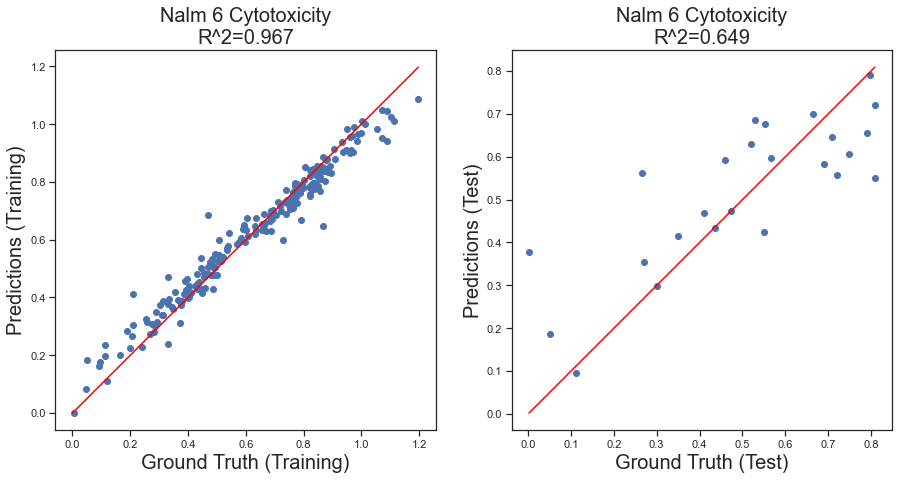

In [239]:
from sklearn.metrics import r2_score
title_list=['Nalm 6 Cytotoxicity','IL7RaKLRG1 stemness']
plt.figure(figsize=[15,70])
i=0
gt=Y_train*max_y
plt.subplot(1,2,1)
plt.scatter(gt,pred_train)
xmin=min(min(gt),min(pred_train))
xmax=max(max(gt),max(pred_train))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Training)', fontsize=20)
plt.ylabel('Predictions (Training)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_train)
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')

plt.subplot(1,2,2)
gt=Y_test*max_y
plt.scatter(gt,pred_test)
xmin=min(min(gt),min(pred_test))
xmax=max(max(gt),max(pred_test))
xline=np.linspace(xmin,xmax,10)
plt.plot(xline,xline,color='red')
plt.xlabel('Ground Truth (Test)', fontsize=20)
plt.ylabel('Predictions (Test)', fontsize=20)
correlation_matrix = np.corrcoef(gt, pred_test)
corr = correlation_matrix[0,1]
r_squared = corr**2
plt.title(title_list[i]+'\n'+'R^2='+str(r_squared)[:5], fontsize=20)
plt.axis('square')